# Using Lags to Handle Partial Observability

For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/rnns_for_pomdp

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import PPO
from relax.rl.critics import GAE

from relax.zoo.policies import NormalMLP, NormalLSTM
from relax.zoo.critics import VMLP, VLSTM

from relax.data.sampling import Sampler

from relax.gym.utils import visualize_actor

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In case of partial observability (POMDP - Partially Observed Markov Decision Process) __observations__ returned by the environment does not give the full information about actual environment's __state__. One way to mitigate this problem is to feed policy network with current + N most recent observations instead of the only current one. In theory, this should allow RL actor to reconstruct actual state from recent observations history. 

__ReLAx__ package offers a simple API to work with lagged observations with the minimal amount of extra coding.

# Creating POMDP environment

To simulate partial observability in a controlled manner we will create a `gym.Wrapper` which masks observations array with zeros with `eps` probability. Through altering `eps` we will control the degree of partial observaility in our experiments.

`ZerosMask` is also available through `relax.gym.wrappers.custom`

In [2]:
class ZerosMask(gym.Wrapper):  
    
    """
    Masks observation's array with zeros with `eps` probability.
    To simulate partial observability in a controlled manner.
    """
    
    def __init__(self, env, eps):
        
        gym.Wrapper.__init__(self, env)
        self.eps = eps
        
    def _mask_obs(self, obs):
        
        # create zero mask according to eps probability
        zero_mask = np.random.uniform(size=obs.shape) > self.eps
        
        # apply mask
        masked_obs = obs * zero_mask
        
        return masked_obs.copy()
    
    def step(self, action):
        
        # Step an unwrapped environment
        obs, reward, done, info = self.env.step(action)
        
        return self._mask_obs(obs), reward, done, info
    
    def reset(self):
        return self._mask_obs(self.env.reset())

# PPO-GAE actor

!Note: For this example we will use PPO-GAE as a base algorithm. We will also use the same setting as in [PPO-GAE example](https://github.com/nslyubaykin/relax_ppo_example/blob/master/ppo_example.ipynb) and for brevity of the tutorial detailed PPO-GAE explanation will be omitted.

!Note: You can use lags with any ReLAx algorithms the same way.

# Creating Lagged Policy Network

To process lags history we will use a reccurent neural network with Long Short-Term Memory (LSTM) which parametrises normal distribution.

So let's examine the default implementation of stochastic LSTM offered by ReLAx:

In [3]:
print(getsource(NormalLSTM))

class NormalLSTM(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 seq_len, nlayers_lstm,
                 nunits_lstm, nunits_dense, activation=nn.Tanh(),
                 out_activation=nn.Identity(),
                 acs_scale=1, acs_bias=0,
                 init_log_std=0.0,
                 pre_process_module=None):
        
        super(NormalLSTM, self).__init__()
        
        self.pre_process_module = pre_process_module
        self.lstm = nn.LSTM(obs_dim, nunits_lstm, nlayers_lstm)
        self.dense1 = nn.Linear(nunits_lstm, nunits_dense)
        self.act_dense1 = activation
        self.flatten = nn.Flatten()
        self.dense_out = nn.Linear(nunits_dense * seq_len, acs_dim)
        self.act_out = out_activation
        
        self.log_stds = nn.Parameter(
            torch.ones(acs_dim) * init_log_std
        )
        
        self.acs_scale = acs_scale
        self.acs_bias = acs_bias   
        
    def forward(self, x):
        
       

# Creating Lagged Value Function For GAE

Let's examine the default implementation of VLSTM offered by ReLAx:

In [4]:
print(getsource(VLSTM))

class VLSTM(nn.Module):
    
    def __init__(self, obs_dim, 
                 seq_len, nlayers_lstm,
                 nunits_lstm, nunits_dense,
                 activation=nn.Tanh(),
                 out_activation=nn.Identity(),
                 pre_process_module=None):
        
        super(VLSTM, self).__init__()
        
        self.pre_process_module = pre_process_module
        self.lstm = nn.LSTM(obs_dim, nunits_lstm, nlayers_lstm)
        self.dense1 = nn.Linear(nunits_lstm, nunits_dense)
        self.act_dense1 = activation
        self.flatten = nn.Flatten()
        self.dense_out = nn.Linear(nunits_dense * seq_len, 1)
        self.act_out = out_activation
        
        
    def forward(self, x):
        
        if self.pre_process_module is not None:
            x = self.pre_process_module(x)
            
        h, _ = self.lstm(x)
        dense1 = self.dense1(h)
        dense1 = self.act_dense1(dense1)
        flatten = self.flatten(dense1)
        dense_out = sel

# Creating Lags with ReLAx

ReLAx offers a simple interface to use lagged observations by specifying the following args:

`obs_nlags`: int - specify the number of lags in addition to current observation

`obs_expand_axis`: int or None - if not None, creates an extra dimension in observation array to concat along, if needed

`obs_concat_axis`: int - axis to concatenate lags along

`obs_padding`: str - ('zeros', 'first') value to pad starting observations with.

Input shape for LSTM layer is (BATCH_SIZE, SEQ_LEN, OBS_DIM), so by specifying:

`obs_nlags`=N

`obs_expand_axis`=0

`obs_concat_axis`=0

`obs_padding`='zeros'

We end up with a stacked lagged observation with a shape (BATCH_SIZE, N+1, OBS_DIM)

__To ensure correct lags usage these args should be provided both to learners and samplers.__

__Note!: Actor and critic may have different lags settings.__

# Run Experiments In a Loop:

In [18]:
# Experiment Settings:

eps_grid = [0.0, 0.25, 0.5, 0.75] 
n_lags = 15

env_name = 'InvertedPendulum-v2'

acs_dim = 1
obs_dim = 4
n_experiments = 4
n_steps = 40 

logdir = '/home/nikita/Desktop/RelaxExamples/POMDP/tensorboard_logs'
log_every = 1
logs_by_run = {}

In [19]:
for eps in eps_grid:
    
    logs_by_run[f'eps_val_{eps}'] = {}
    
    ########################
    # Running unlagged PPO #
    ########################
    
    print(f'Running 0-lag PPO, eps = {eps}...')
    
    # Logging
    run_name = f'0_lag_ppo_{env_name}_eps_{eps}'
    logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
    all_logs = []
    
    # Create training and eval environments
    env = ZerosMask(
        env=gym.make(env_name),
        eps=eps
    )
    eval_env = ZerosMask(
        env=gym.make(env_name),
        eps=eps
    )
    eval_env.seed(np.random.randint(100))
    
    # Actor & critic:
    actor = PPO(
        policy_net=NormalMLP(obs_dim, acs_dim, 
                             nunits=32, nlayers=2,
                             out_activation=torch.nn.Identity(),
                             init_log_std=-1.0),
        device=torch.device('cuda'),
        learning_rate=1e-3, 
        n_epochs_per_update=20, 
        batch_size=512, 
        target_kl=0.2, 
        eps=0.2,
        gamma=0.99
    )
    
    critic = GAE(
        critic_net=VMLP(obs_dim, nlayers=2, nunits=32),
        device=torch.device('cuda'),
        learning_rate=2e-3,
        batch_size=512,
        gamma=0.99,
        gae_lambda=0.95,
        n_target_updates=1, 
        n_steps_per_update=20
    )

    # provide actor with critic
    actor.set_critic(critic)
    
    # Wrap envs into Sampler
    sampler = Sampler(env=env)
    eval_sampler = Sampler(env=eval_env)
    
    for step in tqdm(range(n_steps)): 
    
        # sample training batch
        train_batch = sampler.sample(actor=actor,
                                     n_transitions=5000,
                                     max_path_length=None, 
                                     reset_when_not_done=False,
                                     train_sampling=True)

        # update critic
        critic_logs = critic.update(train_batch)

        # update actor
        actor_logs = actor.update(train_batch)

        # evaluating the policy
        eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                    n_episodes=5,
                                                    max_path_length=None, 
                                                    train_sampling=False)
        # Logging
        train_logs = train_batch.create_logs(prefix='train')
        eval_logs = eval_batch.create_logs(prefix='eval')

        logs = {**critic_logs,
                **actor_logs,
                **train_logs,
                **eval_logs}
        all_logs.append(logs)

        for key, value in logs.items():
            logger.add_scalar(key, value, step)

    logger.flush()
    
    # Saving run's logs
    logs_by_run[f'eps_val_{eps}'][run_name] = all_logs
    
    # Saving models:
    actor.save_checkpoint('trained_models', run_name+'_actor')
    critic.save_checkpoint('trained_models', run_name+'_critic')
    
    ####################
    # Running LSTM PPO #
    ####################
    
    print(f'Running {n_lags}-lag PPO, eps = {eps}...')
    
    # Logging
    run_name = f'{n_lags}_lag_ppo_{env_name}_eps_{eps}'
    logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
    all_logs = []
    
    # Create training and eval environments
    env = ZerosMask(
        env=gym.make(env_name),
        eps=eps
    )
    eval_env = ZerosMask(
        env=gym.make(env_name),
        eps=eps
    )
    eval_env.seed(np.random.randint(100))
    
    # Actor & critic:
    actor = PPO(
        policy_net=NormalLSTM(obs_dim, acs_dim, nlayers_lstm=2,
                              seq_len=1+n_lags,
                              nunits_lstm=32, nunits_dense=8, 
                              out_activation=torch.nn.Identity(),
                              init_log_std=-1.0),
        device=torch.device('cuda'),
        learning_rate=1e-3, 
        n_epochs_per_update=20, 
        batch_size=512, 
        target_kl=0.2, 
        eps=0.2,
        gamma=0.99,
        obs_nlags=n_lags,
        obs_expand_axis=0,
        obs_concat_axis=0,
        obs_padding='zeros'
    )
    
    critic = GAE(
        critic_net=VLSTM(obs_dim, nlayers_lstm=2,
                         seq_len=1+n_lags,
                         nunits_lstm=32, nunits_dense=8),
        device=torch.device('cuda'),
        learning_rate=1e-3,
        batch_size=512,
        gamma=0.99,
        gae_lambda=0.95,
        n_target_updates=1, 
        n_steps_per_update=20,
        obs_nlags=n_lags,
        obs_expand_axis=0,
        obs_concat_axis=0,
        obs_padding='zeros'
    )

    # provide actor with critic
    actor.set_critic(critic)
    
    # Wrap envs into Sampler
    sampler = Sampler(env=env,
                      obs_nlags=n_lags,
                      obs_expand_axis=0,
                      obs_concat_axis=0,
                      obs_padding='zeros')
    eval_sampler = Sampler(env=eval_env,
                           obs_nlags=n_lags,
                           obs_expand_axis=0,
                           obs_concat_axis=0,
                           obs_padding='zeros')
    
    for step in tqdm(range(n_steps)): 
    
        # sample training batch
        train_batch = sampler.sample(actor=actor,
                                     n_transitions=5000,
                                     max_path_length=None, 
                                     reset_when_not_done=False,
                                     train_sampling=True)

        # update critic
        critic_logs = critic.update(train_batch)

        # update actor
        actor_logs = actor.update(train_batch)

        # evaluating the policy
        eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                    n_episodes=5,
                                                    max_path_length=None, 
                                                    train_sampling=False)
        # Logging
        train_logs = train_batch.create_logs(prefix='train')
        eval_logs = eval_batch.create_logs(prefix='eval')

        logs = {**critic_logs,
                **actor_logs,
                **train_logs,
                **eval_logs}
        all_logs.append(logs)

        for key, value in logs.items():
            logger.add_scalar(key, value, step)

    logger.flush()
    
    # Saving run's logs
    logs_by_run[f'eps_val_{eps}'][run_name] = all_logs
    
    # Saving models:
    actor.save_checkpoint('trained_models', run_name+'_actor')
    critic.save_checkpoint('trained_models', run_name+'_critic')

Running 0-lag PPO, eps = 0.0...


100%|██████████| 40/40 [22:16<00:00, 33.40s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 15-lag PPO, eps = 0.0...


100%|██████████| 40/40 [33:32<00:00, 50.31s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 0-lag PPO, eps = 0.25...


100%|██████████| 40/40 [19:59<00:00, 29.99s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 15-lag PPO, eps = 0.25...


100%|██████████| 40/40 [31:01<00:00, 46.55s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 0-lag PPO, eps = 0.5...


100%|██████████| 40/40 [14:48<00:00, 22.21s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 15-lag PPO, eps = 0.5...


100%|██████████| 40/40 [26:33<00:00, 39.84s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 0-lag PPO, eps = 0.75...


100%|██████████| 40/40 [14:12<00:00, 21.30s/it]
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler
Running 15-lag PPO, eps = 0.75...


100%|██████████| 40/40 [24:35<00:00, 36.90s/it]

Saved checkpoints for PPO...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler



/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [17]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/POMDP/tensorboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10006), started 4:47:09 ago. (Use '!kill 10006' to kill it.)

# Plot learning curves

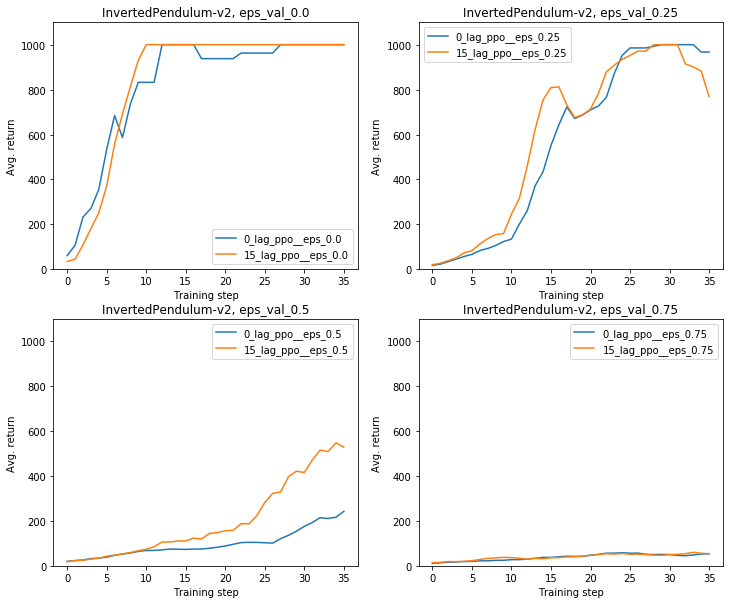

In [38]:
plt.rcParams['figure.figsize'] = (12, 10)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

c=1
for exp_name, exp_data in logs_by_run.items():
    plt.subplot(2, 2, c)
    for k, v in exp_data.items():
        avg_return = [l['avg_return/eval'] for l in v]
        plt.plot(moving_average(avg_return, 5), label=k.replace(env_name, ''))
        plt.xlabel('Training step')
        plt.ylabel('Avg. return')
        plt.ylim(0, 1100)
    plt.legend()
    plt.title(f'{env_name}, {exp_name}')
    c+=1
plt.show()